# Post-processing in the QGS model with a Newtonian cooling coefficient model change

## Preamble

This notebook comes as a supplementary material to the article [Correcting for Model Changes in Statistical Post-Processing – An approach based on Response Theory](https://www.nonlin-processes-geophys-discuss.net/npg-2019-57/):

* Demaeyer, J. and Vannitsem, S.: Correcting for Model Changes in Statistical Post-Processing – An approach based on Response Theory, Nonlin. Processes Geophys. Discuss., https://doi.org/10.5194/npg-2019-57, in review, 2019. 

and details the computations performed to obtain the results therein.

This is a proof-of-concept experiment with a model version representing reality and two other representing a model forecasting the reality:
* Model 0 before a change to improve the forecasting
* Model 1 after the change

The present notebook aims to show how response theory can help to correct the effect of such a model change to an EVMOS post-processing correction.

It produces the figures of the article and relies on the 2-layer quasi-geostrophic [qgs model](https://github.com/Climdyn/qgs) coupled to an orography. The model change here is a change of the parameter $h_d$ (see [qgs documentation](https://qgs.readthedocs.io/)) controlling the strength of the meridional temperature gradient (Newtonian cooling).

### Requirements

The present notebook was tested on a computer with 

* 96 recent cpu cores,
* 64 Gb of RAM,

the whole computation during about an hour.
About 9 Gb of hard drive disk space are also used to store temporarily the model's trajectories data.
Less powerfull machines might work provided that one adapts the number of trajectories used
to compute the statistics.

### Installation

To install this notebook, you must first install the [qgs model](https://github.com/Climdyn/qgs) and test that it works properly on your machine. Follow the instructions in the model documentation. Then you must move the present notebook in the `notebooks` directory and run it with `jupyter-notebook`. In the qgs model main folder, do:

    conda activate qgs
    cd notebooks
    jupyter-notebook

It will open a page in a web browser where you can open and then run the present notebook.

We now proceed to the code itself:

## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':16})

In [5]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm

Initializing the random number generator (for reproducibility). -- Comment to disable if needed.

In [6]:
np.random.seed(21217)

Importing the model's modules

In [7]:
from params.params import QgParams
from integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from integrators.statistics import TrajectoriesStatistics
from functions.tendencies import create_tendencies
from plotting.util import std_plot

Ignoring Numba performance warnings. -- Comment to disable if you want to see them.

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Systems definition

Number of trajectories parameters 

In [9]:
number_of_trajectories = 1000000
number_of_perturbed_trajectories = 10000  # used to compute the response with the tangent model

Time parameters

In [10]:
# Time parameters
dt = 0.1
# Saving the model state every time unit
write_steps = np.int(1/dt)

# Time for convergence to attractor
t_conv = 100000.
t_reconv = 400.

# Forecasts lead time
tau=200.

Model error and perturbation parameters defining the model change

In [11]:
# Initial model error
mod_err = 0.03
# Correction of the model error induced by the model change
eps = 0.015

### Defining the reality ($x$)

Setting reality specific parameters

In [12]:
# Reality parameters instantiation
reality_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.3, 'kd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
reality_parameters.set_max_atmospheric_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
reality_parameters.scale_params.hk[1] = 0.4
reality_parameters.atemperature_params.thetas[0] = 0.2

And defining the tendencies

In [13]:
fx, Dfx = create_tendencies(reality_parameters)

Defining some strings to use in the graphics

In [14]:
vs = list()

for i in range(reality_parameters.nmod[0]):
    vs.append(r'\psi_{' + str(i + 1) + "}")
for i in range(reality_parameters.nmod[0]):
    vs.append(r'\theta_{' + str(i + 1) + "}")

### Defining the model 0 ($y$)

Setting model 0 specific parameters

In [15]:
# Model 0 parameters instantiation
model0_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.3+mod_err, 'kd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model0_parameters.set_max_atmospheric_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model0_parameters.scale_params.hk[1] = 0.4
model0_parameters.atemperature_params.thetas[0] = 0.2

# Defining the dimensional time conversion factor
ct = model0_parameters.dimensional_time

And defining the tendencies

In [16]:
fy, Dfy, model0_tensor = create_tendencies(model0_parameters, return_qgtensor=True)

### Defining the model change leading to 1 ($\hat y$)

Setting model 1 specific parameters

In [17]:
# Model 1 parameters instantiation
model1_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.3+mod_err, 'kd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model1_parameters.set_max_atmospheric_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model1_parameters.scale_params.hk[1] = 0.4
model1_parameters.atemperature_params.thetas[0] = 0.2
# Applying the model change
model1_parameters.atemperature_params.hd -= eps

Defining the perturbation associated to this model change

In [18]:
from inner_products.analytic import AtmosphericInnerProducts
from tensors.qgtensor import QgsTensor
from tensors.cootensor import from_csr_mat_list
from functions.sparse import sparse_mul3

# First let's define the perturbation tensor
aip_pert = AtmosphericInnerProducts(model1_parameters)
tensor_pert = QgsTensor(aip_pert, None)
coo_tensor_pert = from_csr_mat_list(tensor_pert.tensor)
jcoo_tensor_pert = from_csr_mat_list(tensor_pert.jacobian_tensor)

coo_model0_tensor = from_csr_mat_list(model0_tensor.tensor)
jcoo_model0_tensor = from_csr_mat_list(model0_tensor.jacobian_tensor)

coo_tensor_pert.value -= coo_model0_tensor.value
jcoo_tensor_pert.value -= jcoo_model0_tensor.value

coo_tensor_pert.clean_entries()
jcoo_tensor_pert.clean_entries()

# Then the pertubation itself

coo_pert = coo_tensor_pert.coo
val_pert = coo_tensor_pert.value

@njit
def model_change(t, x):
    xx = np.concatenate((np.full((1,), 1.), x))
    xr = sparse_mul3(coo_pert, val_pert, xx, xx)
    return xr[1:]

# and finally the model 1 tendencies

@njit
def fhaty(t, x):
    return fy(t, x) + model_change(t, x)


## First integration

In [19]:
# Defining an integrator for the reality

integrator_x = RungeKuttaIntegrator()
integrator_x.set_func(fx)

In [20]:
# Creating another integrators for the model 0

integrator_y = RungeKuttaIntegrator()
integrator_y.set_func(fy)

 Determine an initial condition on the attractors

In [21]:
%%time
ic = np.random.rand(reality_parameters.ndim)*0.1
integrator_x.integrate(0., 100000., 0.1, ic=ic, write_steps=0)
time, ic_reality = integrator_x.get_trajectories()

CPU times: user 15.9 ms, sys: 36.1 ms, total: 52 ms
Wall time: 8.56 s


In [22]:
%%time
ic = np.random.rand(model0_parameters.ndim)*0.1
integrator_y.integrate(0., 100000., 0.1, ic=ic, write_steps=0)
time, ic_model = integrator_y.get_trajectories()

CPU times: user 14.5 ms, sys: 46.3 ms, total: 60.8 ms
Wall time: 8.5 s


And then an integration to obtain a trajectory on the attractor

In [23]:
%%time
integrator_x.integrate(0., 50000., 0.1, ic=ic_reality, write_steps=5)
time, trajx = integrator_x.get_trajectories()

CPU times: user 15.8 ms, sys: 73.5 ms, total: 89.3 ms
Wall time: 5.83 s


In [24]:
%%time
integrator_y.integrate(0., 50000., 0.1, ic=ic_model, write_steps=5)
time, trajy = integrator_y.get_trajectories()

CPU times: user 18.5 ms, sys: 53.2 ms, total: 71.7 ms
Wall time: 5.96 s


Finding the fixed points of the reality ($x$)

In [25]:
# Defining a function without time dependence
@njit
def fxnt(x):
    return fx(0.,x)

from scipy.optimize import root

eps = 1.e-6
fixed_point = list()

for i in range(2000):
    sol = root(fxnt, trajx[:,i])
    if sol.success:
        for x in fixed_point:
            if np.linalg.norm(x-sol.x) < eps:
                break
        else:
            fixed_point.append(sol.x)
            


reality_fixed_point = np.array(fixed_point)

Finding the fixed points of the model 0 ($y$)

In [26]:
# Defining a function without time dependence
@njit
def fynt(x):
    return fy(0.,x)

from scipy.optimize import root

eps = 1.e-6
fixed_point = list()

for i in range(2000):
    sol = root(fynt, trajy[:,i])
    if sol.success:
        for x in fixed_point:
            if np.linalg.norm(x-sol.x) < eps:
                break
        else:
            fixed_point.append(sol.x)
            


model0_fixed_point = np.array(fixed_point)

Plotting the result in 3D and 2D

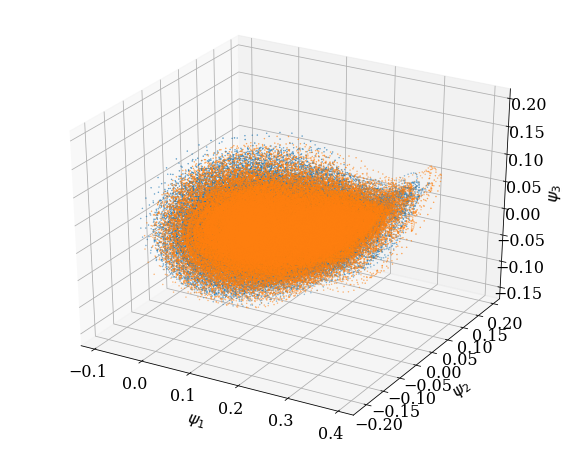

In [27]:
fig = plt.figure(figsize=(10, 8))
axi = fig.gca(projection='3d')

axi.scatter(trajx[0], trajx[1], trajx[2], s=0.2);
axi.scatter(trajy[0], trajy[1], trajy[2], s=0.2);

axi.set_xlabel('\n$'+vs[0]+'$')
axi.set_ylabel('\n$'+vs[1]+'$')
axi.set_zlabel('\n$'+vs[2]+'$');


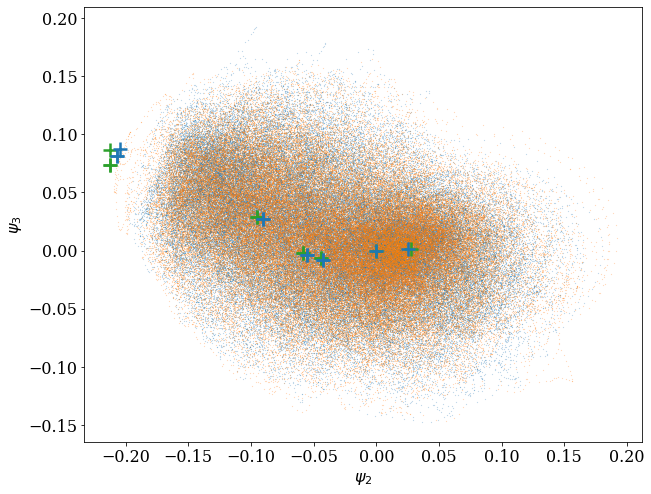

In [28]:
varx = 1
vary = 2
plt.figure(figsize=(10, 8))

plt.plot(trajx[varx], trajx[vary], marker='o', ms=0.1, ls='')
plt.plot(trajy[varx], trajy[vary], marker='o', ms=0.1, ls='')

#Plotting the fix point also
plt.plot(reality_fixed_point[:,varx], reality_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='tab:blue', ls='', zorder=300.)
plt.plot(model0_fixed_point[:,varx], model0_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='tab:green', ls='', zorder=200.)

plt.xlabel('$'+vs[varx]+'$')
plt.ylabel('$'+vs[vary]+'$');

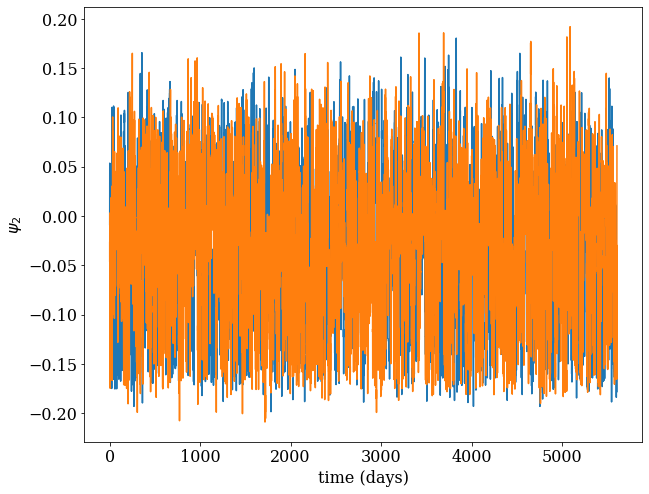

In [29]:
var = 1
plt.figure(figsize=(10, 8))

plt.plot(model0_parameters.dimensional_time*time, trajx[var])
plt.plot(model0_parameters.dimensional_time*time, trajy[var])

plt.xlabel('time (days)')
plt.ylabel('$'+vs[var]+'$');

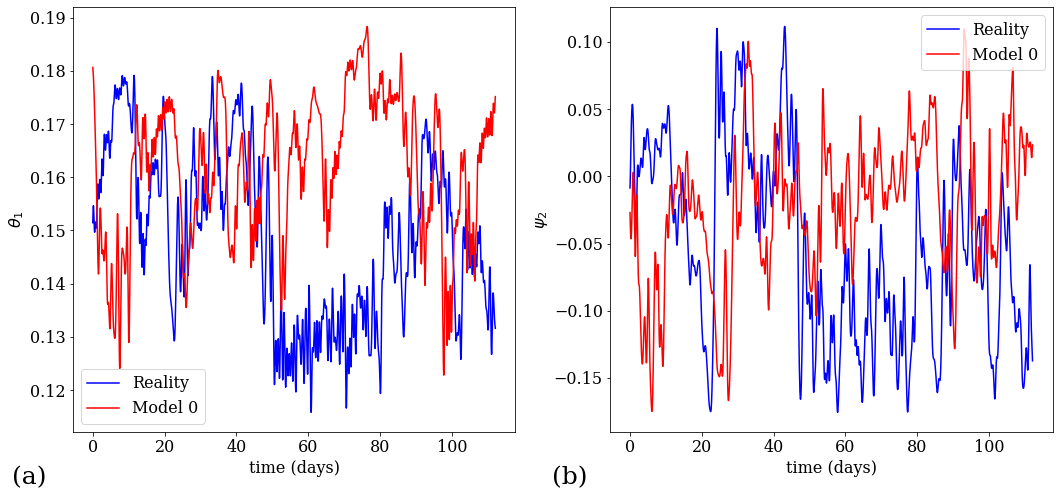

In [30]:
mt=2000
var = 10

fig = plt.figure(figsize=(15,7))
axi = fig.add_subplot(121)

axi.plot(ct*time[:mt], trajx[var,:mt],label='Reality', color='b')
axi.plot(ct*time[:mt], trajy[var,:mt],label='Model 0', color='r')

axi.set_xlabel('time (days)')
axi.set_ylabel('$'+vs[var]+'$');
axi.legend()

axi = fig.add_subplot(122)
var = 1

axi.plot(ct*time[:mt], trajx[var,:mt],label='Reality', color='b')
axi.plot(ct*time[:mt], trajy[var,:mt],label='Model 0', color='r')

axi.set_xlabel('time (days)')
axi.set_ylabel('$'+vs[var]+'$');
axi.legend()

fig.text(0.02,0.02,'(a)', fontsize=25)
fig.text(0.52,0.02,'(b)', fontsize=25);

plt.tight_layout()

#fig.savefig('./fig01.pdf', dpi=300);


Computing and plotting isodensity lines

In [31]:
%%time
# For the reality x

xmin = min((trajx[varx].min(), trajy[varx].min(), reality_fixed_point[:, varx].min(), model0_fixed_point[:, varx].min()))
xmax = max((trajx[varx].max(), trajy[varx].max(), reality_fixed_point[:, varx].max(), model0_fixed_point[:, varx].max()))
ymin = min((trajx[vary].min(), trajy[vary].min(), reality_fixed_point[:, vary].min(), model0_fixed_point[:, vary].min()))
ymax = max((trajx[vary].max(), trajy[vary].max(), reality_fixed_point[:, vary].min(), model0_fixed_point[:, vary].max()))

Xx, Yx = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([Xx.ravel(), Yx.ravel()])

kernelx = gaussian_kde(trajx[(varx, vary), :])
Zx = np.reshape(kernelx(positions).T, Xx.shape)

CPU times: user 31.4 s, sys: 479 ms, total: 31.9 s
Wall time: 23 s


In [32]:
%%time
# For the model 0

kernely = gaussian_kde(trajy[(varx, vary), :])
Zy = np.reshape(kernely(positions).T, Xx.shape)

CPU times: user 30.9 s, sys: 395 ms, total: 31.2 s
Wall time: 22.8 s


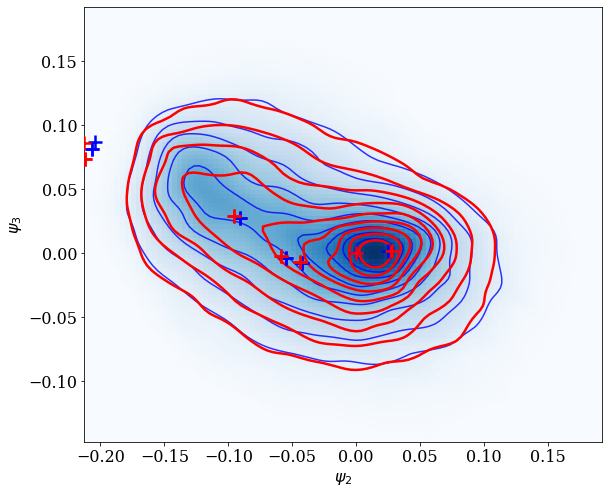

In [33]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

bound = 2.
normx = kernelx.integrate_box((-bound, -bound), (bound, bound))
normy = kernely.integrate_box((-bound, -bound), (bound, bound))

ax.imshow(np.rot90(Zx), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])
ax.contour(Xx, Yx, Zx/Zx.max(), colors=['blue'], extent=[xmin, xmax, ymin, ymax], alpha=0.8, levels=10)
ax.contour(Xx, Yx, Zy/Zy.max(), colors=['red'], extent=[xmin, xmax, ymin, ymax], alpha=1.,linewidths=2.5, levels=10);

plt.plot(reality_fixed_point[:,varx], reality_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='blue', ls='', zorder=200.)
plt.plot(model0_fixed_point[:,varx], model0_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='red', ls='', zorder=200.)


plt.xlabel('$'+vs[varx]+'$')
plt.ylabel('$'+vs[vary]+'$');

Computing the average of the model fields over two different regions of the global attractor (blocked and zonal regime)

In [34]:
def radius(x,v,i,j):
    return np.sqrt((v[i]-x[0])**2+(v[j]-x[1])**2)

varx = 1
vary = 2

xr1 = np.mean(trajy[:, radius((0.0,0.0),trajy,varx, vary) < 0.1], axis=1)
xr2 = np.mean(trajy[:, radius((-0.125,0.04),trajy,varx, vary) < 0.1], axis=1)


Plotting the result

In [35]:
def Fi(i,x,y):
    w=aip_pert.atmospheric_wavenumbers[i]
    Nx=w.nx
    Ny=w.ny
    if w.type=='A':
        return np.sqrt(2)*np.cos(Ny*y)
    elif w.type=='K':
        return 2*np.cos(model0_parameters.scale_params.n*Nx*x)*np.sin(Ny*y)
    else:
        return 2*np.sin(model0_parameters.scale_params.n*Nx*x)*np.sin(Ny*y)

In [36]:
delta=0.025
x = np.arange(0., 2*np.pi/model0_parameters.scale_params.n, delta)
y = np.arange(0., np.pi, delta)
X, Y = np.meshgrid(x, y)

In [37]:
Fim = np.zeros((X.shape[0], X.shape[1], len(aip_pert.atmospheric_wavenumbers)))
for i in range(len(aip_pert.atmospheric_wavenumbers)):
    Fim[:,:,i] = Fi(i,X,Y)

In [38]:
def map_to_field(X):
    return Fim @ X

In [39]:
rpr = model0_parameters.scale_params.L**2*model0_parameters.scale_params.f0 
geo = model0_parameters.scale_params.f0 /9.81

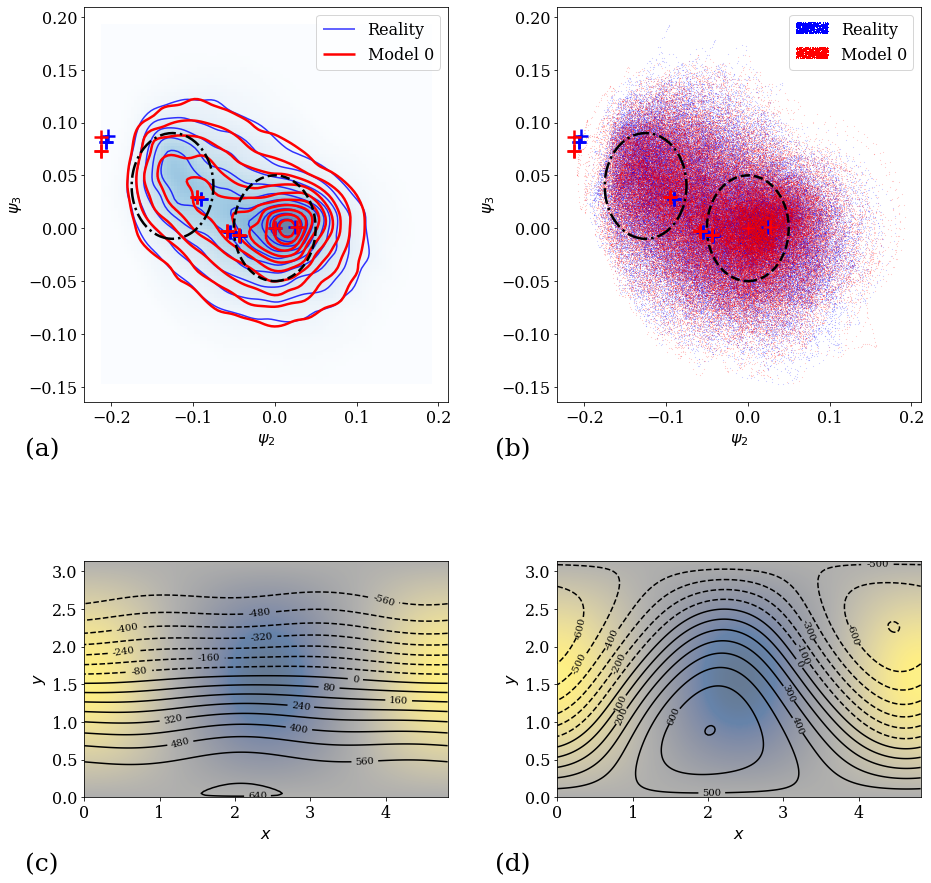

In [40]:
import matplotlib.lines as lines
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.legend_handler import HandlerBase

class ObjHandler(HandlerBase):
    
    def __init__(self, npx=1000, **kw):
        
        HandlerBase.__init__(self, **kw)
        
        self.npx = npx
    
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        
        xr=np.random.rand(self.npx)
        yr=np.random.rand(self.npx)

        x0 ,y0 = xdescent + xr*width, ydescent + yr*height
        leg=lines.Line2D(x0,y0,ls='',marker=',',color=orig_handle.get_color())
        
        leg.set_transform(trans)
        
        return [leg]

bound = 2.
normx = kernelx.integrate_box((-bound, -bound), (bound, bound))
normy = kernely.integrate_box((-bound, -bound), (bound, bound))

fig = plt.figure(figsize=(15,16))

#axi = fig.add_subplot(221, projection='3d')

#axi.scatter(trajx[0], trajx[1], trajx[2], s=0.05,label='Reality', color='b');
#axi.scatter(trajy[0], trajy[1], trajy[2], s=0.06,label='Model 0', color='r');
#scatter1_proxy = lines.Line2D([0],[0], linestyle="none", c='b', ms=0.05)
#scatter2_proxy = lines.Line2D([0],[0], linestyle="none", c='r', ms=0.06)

#axi.set_xlabel('$'+vs[0]+'$')
#axi.set_ylabel('\n$'+vs[1]+'$')
#axi.set_zlabel('\n$'+vs[2]+'$')
#axi.legend([scatter1_proxy, scatter2_proxy], ['Reality', 'Model 0'], handler_map={lines.Line2D: ObjHandler()})

axio = fig.add_subplot(221)

axio.plot(reality_fixed_point[:,varx], reality_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='blue', ls='', zorder=200.)
axio.plot(model0_fixed_point[:,varx], model0_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='red', ls='', zorder=200.)

axio.imshow(np.rot90(Zx), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=0.6)
csx = axio.contour(Xx, Yx, Zx/normx, colors=['blue'], extent=[xmin, xmax, ymin, ymax], alpha=0.8, levels=10)
csy = axio.contour(Xx, Yx, Zy/normy, colors=['red'], extent=[xmin, xmax, ymin, ymax], alpha=1.,linewidths=2.5, levels=10);

csx.collections[0].set_label('Reality')
csy.collections[0].set_label('Model 0')

c1 = mpatches.Ellipse((-0.0,-0.0), width=0.1,height=0.1,edgecolor='k', linestyle='--', lw=2.5, facecolor="none", zorder=100.)
c2 = mpatches.Ellipse((-0.125,0.04), width=0.1,height=0.1, angle=-20, edgecolor='k', linestyle='-.', lw=2.5, facecolor="none", zorder=100.)

axio.add_patch(c1)
axio.add_patch(c2)

axio.set_xlabel('$'+vs[1]+'$')
axio.set_ylabel('$'+vs[2]+'$')

axio.legend()

axi = fig.add_subplot(222)
varx = 1
vary = 2

c1 = mpatches.Ellipse((-0.0,-0.0), width=0.1,height=0.1,edgecolor='k', linestyle='--', lw=2.5, facecolor="none", zorder=100.)
c2 = mpatches.Ellipse((-0.125,0.04), width=0.1,height=0.1, angle=-20, edgecolor='k', linestyle='-.', lw=2.5, facecolor="none", zorder=100.)

axi.add_patch(c1)
axi.add_patch(c2)

axi.plot(trajx[varx], trajx[vary], marker='o', ms=0.07, ls='',label='Reality', color='b')
axi.plot(trajy[varx], trajy[vary], marker='o', ms=0.07, ls='',label='Model 0', color='r')

axi.plot(reality_fixed_point[:,varx], reality_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='blue', ls='', zorder=200.)
axi.plot(model0_fixed_point[:,varx], model0_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='red', ls='', zorder=200.)

axi.set_xlabel('$'+vs[varx]+'$')
axi.set_ylabel('$'+vs[vary]+'$')
axi.legend(handler_map={lines.Line2D: ObjHandler()})

axio.set_xlim(axi.get_xlim())
axio.set_ylim(axi.get_ylim())

axi = fig.add_subplot(223)
x = model0_parameters.scale_params.hk
mapped = map_to_field(x)
#     grad = np.gradient(mapped
#     grad = np.sqrt(grad[0]**2+grad[1]**2)
    
im=axi.imshow(mapped,interpolation='bilinear', cmap=cm.cividis, origin='lower', extent=[0,2*np.pi/model0_parameters.scale_params.n,0,np.pi], alpha=0.6) 
cont = axi.contour(X, Y, map_to_field(geo*rpr*xr1[:int(model0_parameters.ndim/2)]), levels=15, colors='k')
axi.set_xlabel('$x$')
axi.set_ylabel('$y$')
axi.clabel(cont, fontsize=10, fmt='%1.f')

axi = fig.add_subplot(224)
im=axi.imshow(mapped,interpolation='bilinear', cmap=cm.cividis, origin='lower', extent=[0,2*np.pi/model0_parameters.scale_params.n,0,np.pi], alpha=0.6) 
cont = axi.contour(X, Y, map_to_field(geo*rpr*xr2[:int(model0_parameters.ndim/2)]), levels=15, colors='k')
axi.set_xlabel('$x$')
axi.set_ylabel('$y$')
axi.clabel(cont, fontsize=10, fmt='%1.f')

fig.subplots_adjust(wspace=0.3)

fig.text(0.07,0.13,'(c)', fontsize=25)
fig.text(0.505,0.13,'(d)', fontsize=25)

fig.text(0.07,0.49,'(a)', fontsize=25)
fig.text(0.505,0.49,'(b)', fontsize=25);

#fig.savefig('../note/figures/fig02.pdf', dpi=300);
#fig.savefig('../note/figures/fig02.png', dpi=300);


Removing from memory the trajectories computed so far to make some room

In [41]:
del trajx
del trajy

## Post-processing part

### Situation before model change

#### Initialization of the trajectories

To obtain initial conditions on the attractor of the reality

In [42]:
%%time

nut = number_of_trajectories
ndim = model0_parameters.ndim
ic_tmp = np.random.randn(nut, ndim)*0.1
integrator_x.initialize(t_conv, dt, reconvergence_time=t_reconv, reconverge=True, ic=ic_tmp)
ic_tmp = integrator_x.get_ic()

ic_reality = ic_tmp
del ic_tmp, nut

CPU times: user 1min 34s, sys: 22.9 s, total: 1min 57s
Wall time: 20min 53s


#### Generating model 0 and reality means

Creating two statistics structures, one for the reality and one for the model

In [43]:
stats_x = TrajectoriesStatistics()
stats_y = TrajectoriesStatistics()

stats_x.set_integrator(integrator_x)
stats_y.set_integrator(integrator_y)

stats_x.set_ic(ic_reality)
stats_y.set_ic(ic_reality)

We want to compute the first and second moments

In [44]:
func_list = [lambda x: x, lambda x: x * x]

stats_x.set_func_list(func_list)
stats_y.set_func_list(func_list)

Computing the statistics based on the forecast trajectories (and saving the forecasts trajectories for latter)

In [45]:
%%time

stats_x.compute_stats(0., tau, dt, write_steps=write_steps, num=10)
stats_y.compute_stats(0., tau, dt, write_steps=write_steps, num=10)

time0, traj = integrator_x.get_trajectories()
np.savez_compressed("reality_trajectories", traj)
time0, traj = integrator_y.get_trajectories()
np.savez_compressed("model0_trajectories", traj)

n_write = len(time0)

CPU times: user 7min 9s, sys: 3min 12s, total: 10min 21s
Wall time: 21min 35s


In [46]:
mean_func_x = stats_x.get_stats()
mean_func_y = stats_y.get_stats()

In [47]:
mean_traj_reality = mean_func_x[0]
var_traj_reality = mean_func_x[1]-mean_func_x[0]**2
mean_traj_model0 = mean_func_y[0]
var_traj_model0 = mean_func_y[1]-mean_func_y[0]**2

Plotting the intermediate result (mean and variance of the forecasts)

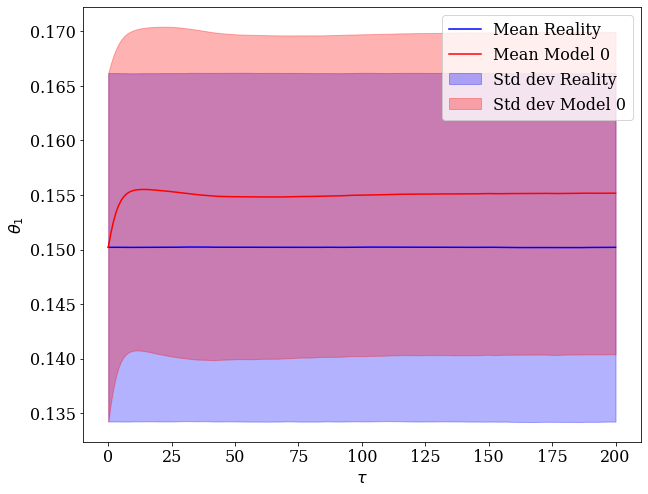

In [48]:
var = 10
plt.figure(figsize=(10, 8))
plt.plot(time0, mean_traj_reality[var], color="b", label='Mean Reality')
plt.fill_between(time0, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3, label='Std dev Reality')
plt.plot(time0, mean_traj_model0[var], color="r", label='Mean Model 0')
plt.fill_between(time0, mean_traj_model0[var]-np.sqrt(var_traj_model0[var]), mean_traj_model0[var]+np.sqrt(var_traj_model0[var]),
                 color='r', alpha=0.3, label='Std dev Model 0')

plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel('$'+vs[var]+'$');


Computing the EVMOS coefficient $\alpha$ and $\beta$

In [49]:
beta0 = np.nan_to_num(np.sqrt(var_traj_reality / var_traj_model0))
alpha0 = mean_traj_reality - beta0 * mean_traj_model0

### Situation after Model Change

#### Reinitialization of the model

With the tendencies of the model 1 ($\hat y$)

In [50]:
integrator_y.set_func(fhaty)

#### Generating model 1 statistics

Computing the statistics based on the trajectories

In [51]:
stats_y.set_ic(ic_reality)

In [52]:
%%time

stats_y.compute_stats(0., tau, dt, write_steps=write_steps, num=10)

time, traj = integrator_y.get_trajectories()
np.savez_compressed("model1_trajectories", traj)

CPU times: user 3min 39s, sys: 1min 53s, total: 5min 32s
Wall time: 13min 40s


In [53]:
mean_func_y = stats_y.get_stats()

In [54]:
mean_traj_model = mean_func_y[0]
var_traj_model = mean_func_y[1] - mean_func_y[0]**2

Plotting the intermediate result (mean and variance of the forecasts)

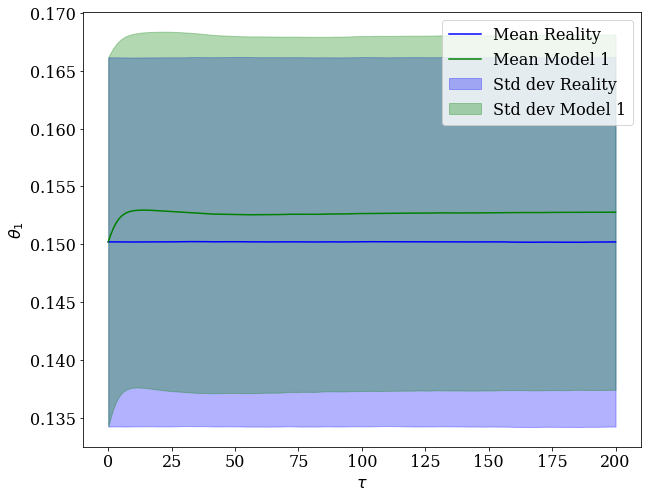

In [55]:
var = 10
plt.figure(figsize=(10, 8))
plt.plot(time, mean_traj_reality[var], color="b", label='Mean Reality')
plt.fill_between(time, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3, label='Std dev Reality')
plt.plot(time, mean_traj_model[var], color="g", label='Mean Model 1')
plt.fill_between(time, mean_traj_model[var]-np.sqrt(var_traj_model[var]), mean_traj_model[var]+np.sqrt(var_traj_model[var]),
                 color='g', alpha=0.3, label='Std dev Model 1')

plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel('$'+vs[var]+'$');


Plotting the results

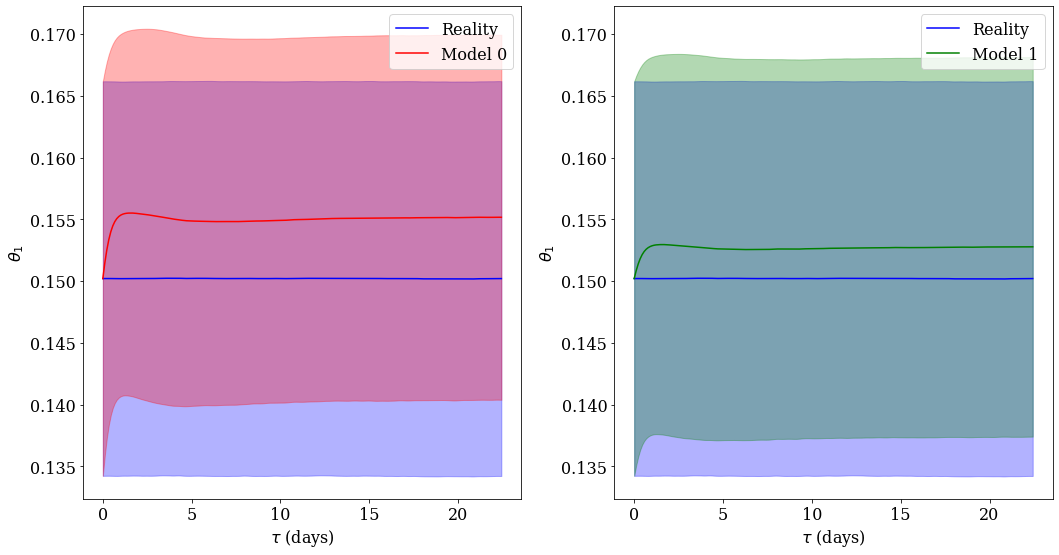

In [56]:
var = 10
fig = plt.figure(figsize=(15, 8))

axi1 = fig.add_subplot(121)

axi1.plot(ct*time, mean_traj_reality[var], color="b", label='Reality')
axi1.fill_between(ct*time, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3)#, label='Reality (standard deviation)')
axi1.plot(ct*time, mean_traj_model0[var], color="r", label='Model 0')
axi1.fill_between(ct*time, mean_traj_model0[var]-np.sqrt(var_traj_model0[var]), mean_traj_model0[var]+np.sqrt(var_traj_model0[var]),
#                  facecolor='none', edgecolor='r', hatch='/', alpha=0.6)#, label='Model 0 (standard deviation)')
                 color='r', alpha=0.3)#, label='Model 0 (standard deviation)')

axi1.legend()
axi1.set_xlabel(r"$\tau$ (days)")
axi1.set_ylabel('$'+vs[var]+'$')

ylim1 = axi1.get_ylim()


axi2 = fig.add_subplot(122)
axi2.plot(ct*time, mean_traj_reality[var], color="b", label='Reality')
axi2.fill_between(ct*time, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3)#, label='Reality (standard deviation)')

axi2.plot(ct*time, mean_traj_model[var], color="g", label='Model 1')
axi2.fill_between(ct*time, mean_traj_model[var]-np.sqrt(var_traj_model[var]), mean_traj_model[var]+np.sqrt(var_traj_model[var]),
#                  facecolor='none', edgecolor='g', hatch='/', alpha=0.6)#, label='Model 0 (standard deviation)')
                 color='g', alpha=0.3)#, label='Model 0 (standard deviation)')
                 
axi2.legend()
axi2.set_xlabel(r"$\tau$ (days)")
axi2.set_ylabel('$'+vs[var]+'$')

ylim2 = axi2.get_ylim()

ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))

axi1.set_ylim(ylim)
axi2.set_ylim(ylim);

plt.tight_layout()
#fig.savefig('./fig03.pdf', dpi=300);

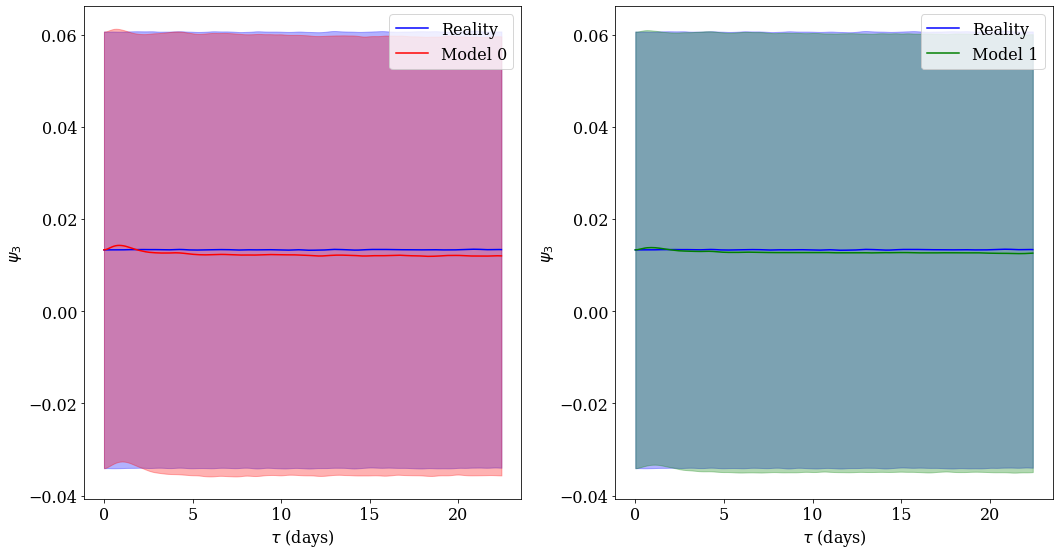

In [57]:
var = 2
fig = plt.figure(figsize=(15, 8))

axi1 = fig.add_subplot(121)

ct = model0_parameters.dimensional_time

axi1.plot(ct*time, mean_traj_reality[var], color="b", label='Reality')
axi1.fill_between(ct*time, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3)#, label='Reality (standard deviation)')
axi1.plot(ct*time, mean_traj_model0[var], color="r", label='Model 0')
axi1.fill_between(ct*time, mean_traj_model0[var]-np.sqrt(var_traj_model0[var]), mean_traj_model0[var]+np.sqrt(var_traj_model0[var]),
#                  facecolor='none', edgecolor='r', hatch='/', alpha=0.6)#, label='Model 0 (standard deviation)')
                 color='r', alpha=0.3)#, label='Model 0 (standard deviation)')

axi1.legend()
axi1.set_xlabel(r"$\tau$ (days)")
axi1.set_ylabel('$'+vs[var]+'$')

ylim1 = axi1.get_ylim()


axi2 = fig.add_subplot(122)
axi2.plot(ct*time, mean_traj_reality[var], color="b", label='Reality')
axi2.fill_between(ct*time, mean_traj_reality[var]-np.sqrt(var_traj_reality[var]), mean_traj_reality[var]+np.sqrt(var_traj_reality[var]),
                 color='b', alpha=0.3)#, label='Reality (standard deviation)')

axi2.plot(ct*time, mean_traj_model[var], color="g", label='Model 1')
axi2.fill_between(ct*time, mean_traj_model[var]-np.sqrt(var_traj_model[var]), mean_traj_model[var]+np.sqrt(var_traj_model[var]),
#                  facecolor='none', edgecolor='g', hatch='/', alpha=0.6)#, label='Model 0 (standard deviation)')
                 color='g', alpha=0.3)#, label='Model 0 (standard deviation)')
                 
axi2.legend()
axi2.set_xlabel(r"$\tau$ (days)")
axi2.set_ylabel('$'+vs[var]+'$')

ylim2 = axi2.get_ylim()

ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))

axi1.set_ylim(ylim)
axi2.set_ylim(ylim);

plt.tight_layout()


#fig.savefig('./fig04.pdf', dpi=300);

Computing the EVMOS coefficient $\alpha$ and $\beta$

In [58]:
beta = np.nan_to_num(np.sqrt(var_traj_reality / var_traj_model))
alpha = mean_traj_reality - beta * mean_traj_model

Releasing the integrators memory

In [59]:
integrator_x.terminate()
integrator_y.terminate()

## Response Theory

We will now compute the response due to the model change on the model 0 observables, using its tangent model.

Defining the observable to be used (First and second moments $\langle x \rangle$ and $\langle x^2 \rangle$) and its Jacobian

In [60]:
@njit
def x2(x):
    return x * x

@njit
def Dx2(x):
    s = x.shape[0]
    a = np.zeros((s, s))
    for i in range(s):
        a[i, i] = 2 * x[i]
        
    return a

Integrating the trajectories of the tangent model ($\delta y(\tau)$)

In [61]:
tgls_integrator = RungeKuttaTglsIntegrator()

In [62]:
tgls_integrator.set_func(fy, Dfy)

In [63]:
%%time 

tgls_integrator.integrate(0., tau, dt=dt, write_steps=write_steps, ic=ic_reality[:number_of_perturbed_trajectories], tg_ic=np.zeros(ndim), boundary=model_change)

CPU times: user 8.95 s, sys: 1.49 s, total: 10.4 s
Wall time: 39.1 s


In [64]:
tt, traj, deltay = tgls_integrator.get_trajectories()

Defining a function to broadcast the multiplication of the tangent state vector with the Jacobian

In [65]:
@njit
def jac_mult(Df, traj, vec):
    jm = np.zeros_like(traj)

    for i in range(traj.shape[0]):
        for j in range(traj.shape[-1]):
            jm[i, :, j] = Df(traj[i, :, j]) @ vec[i, :, j]

    return jm

Computing the response of $\langle x^2 \rangle$

In [66]:
deltay2 = jac_mult(Dx2, traj, deltay)

Plotting the statistic of the tangent trajectories

* With linear scale

-0.002570292266017337 -0.0024695943271019444
-0.002528982574966683 -0.00244712258562261
-0.002462804915591697 -0.0024038878120913824
-0.002396502822443912 -0.0023768708939763883
-0.0023016602490436183 -0.0021652570665122777
-0.0022381462330797676 -0.0023409002508957156
-0.0022736619089541174 -0.002765370742541533
-0.0022066456665315233 -0.002292050310903248
-0.0022834316579831474 -0.002287482675116416
-0.002249102383942284 -0.0027314580323820276
CPU times: user 5.27 s, sys: 632 ms, total: 5.9 s
Wall time: 5.89 s


Text(0.5, 0.92, 'Histogram of $\\delta \\theta_{1} (\\tau)$')

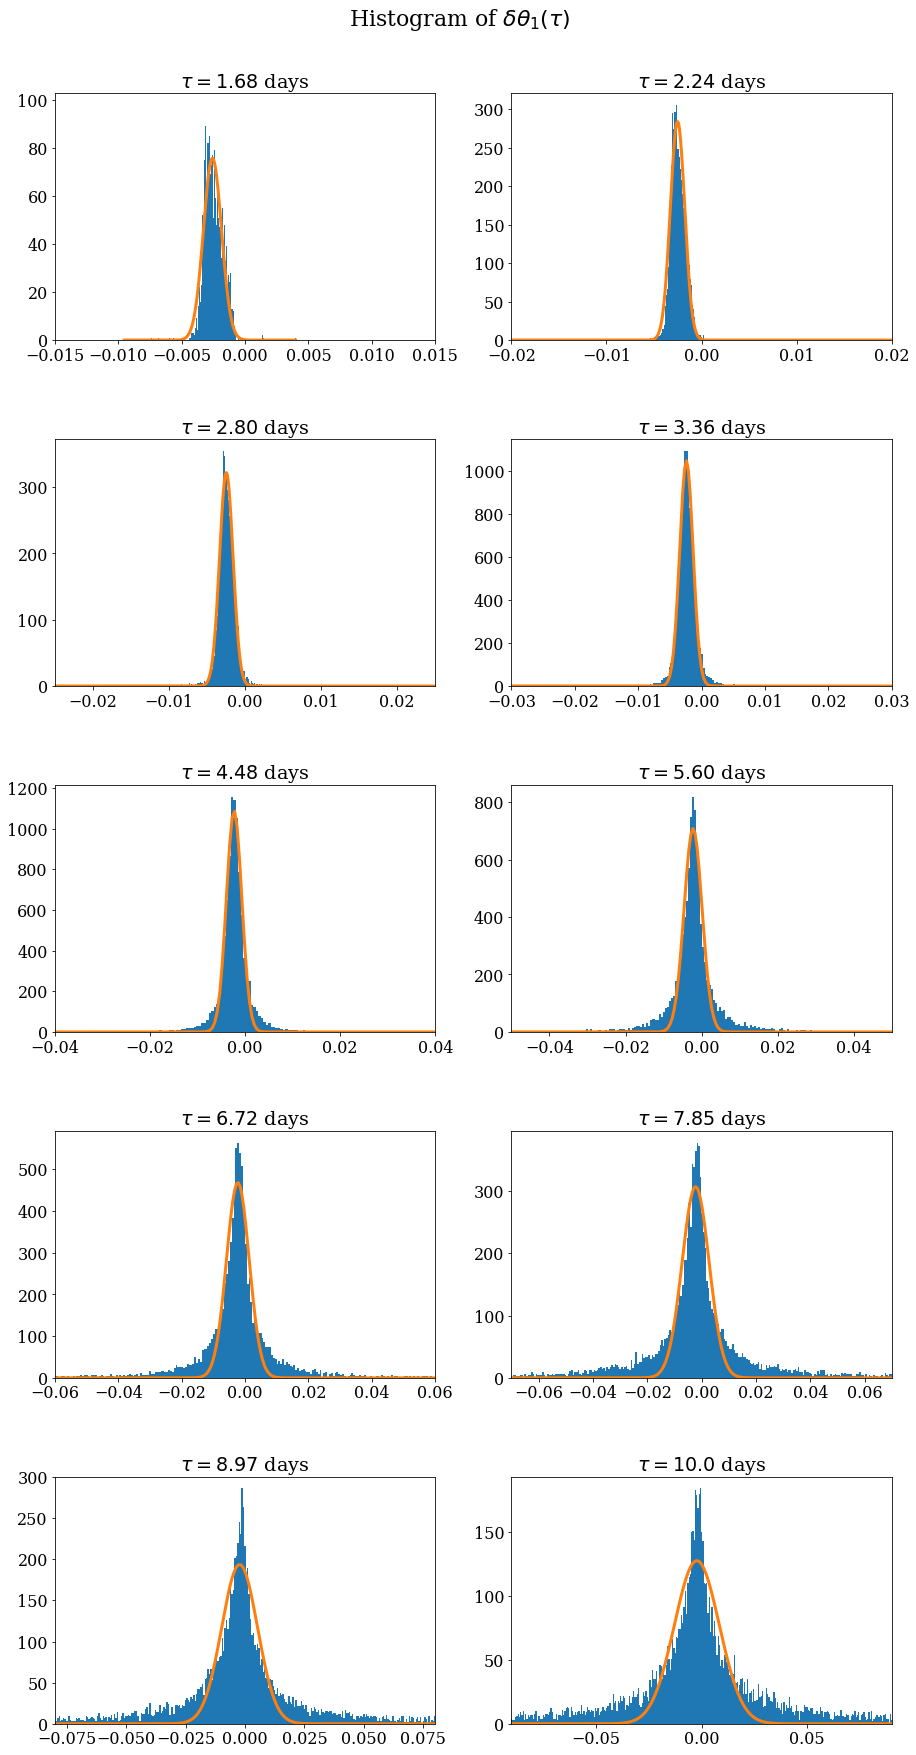

In [67]:
%%time

# Gaussian to make fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Fitting and plotting

var = 10
til = [15]+list(range(20,91,10))
til.insert(2,25)
til = np.array(til)
nbins = [1000]*len(til)
filtl = [0.3]*len(til)
xlim = til*[0.001]

gaussian_parameters = list()

fig, axs = plt.subplots(ncols=2, nrows=int(len(til)/2), figsize=(15,3*len(til)))
plt.subplots_adjust(hspace=0.4)
axsl = axs.flatten()

for i in range(len(til)):
    
    filt = filtl[i]
    ti = til[i]
    fdelta = deltay[abs(deltay[:,var,ti]) < filt, var, ti]
    hist, bins, patchs = axsl[i].hist(fdelta, bins=nbins[i])
    bin_centres = bins[1:] - np.diff(bins)/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [number_of_perturbed_trajectories/nbins[i], -0.001, 0.001]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    gaussian_parameters.append(coeff)
    print(coeff[1],np.mean(fdelta))
    axsl[i].plot(bin_centres, gauss(bin_centres, *coeff), linewidth=3.)
    axsl[i].set_xlim(-xlim[i],xlim[i])
    axsl[i].set_title(r'$\tau='+str(ct*time[ti])[:4]+r'$ days')

    
gaussian_parameters = np.array(gaussian_parameters)
fig.suptitle(r'Histogram of $\delta '+vs[var]+r' (\tau)$', x=0.5, y=0.92, fontsize=22);

#fig.savefig('./fig09.pdf', dpi=300);

* With logarithmic scales (figure 7 of the manuscript)

-0.002570292266017337 -0.0024695943271019444
-0.002528982574966683 -0.00244712258562261
-0.002462804915591697 -0.0024038878120913824
-0.002396502822443912 -0.0023768708939763883
-0.0023016602490436183 -0.0021652570665122777
-0.0022381462330797676 -0.0023409002508957156
-0.0022736619089541174 -0.002765370742541533
-0.0022066456665315233 -0.002292050310903248
-0.0022834316579831474 -0.002287482675116416
-0.002249102383942284 -0.0027314580323820276
CPU times: user 1.49 s, sys: 106 ms, total: 1.59 s
Wall time: 1.61 s


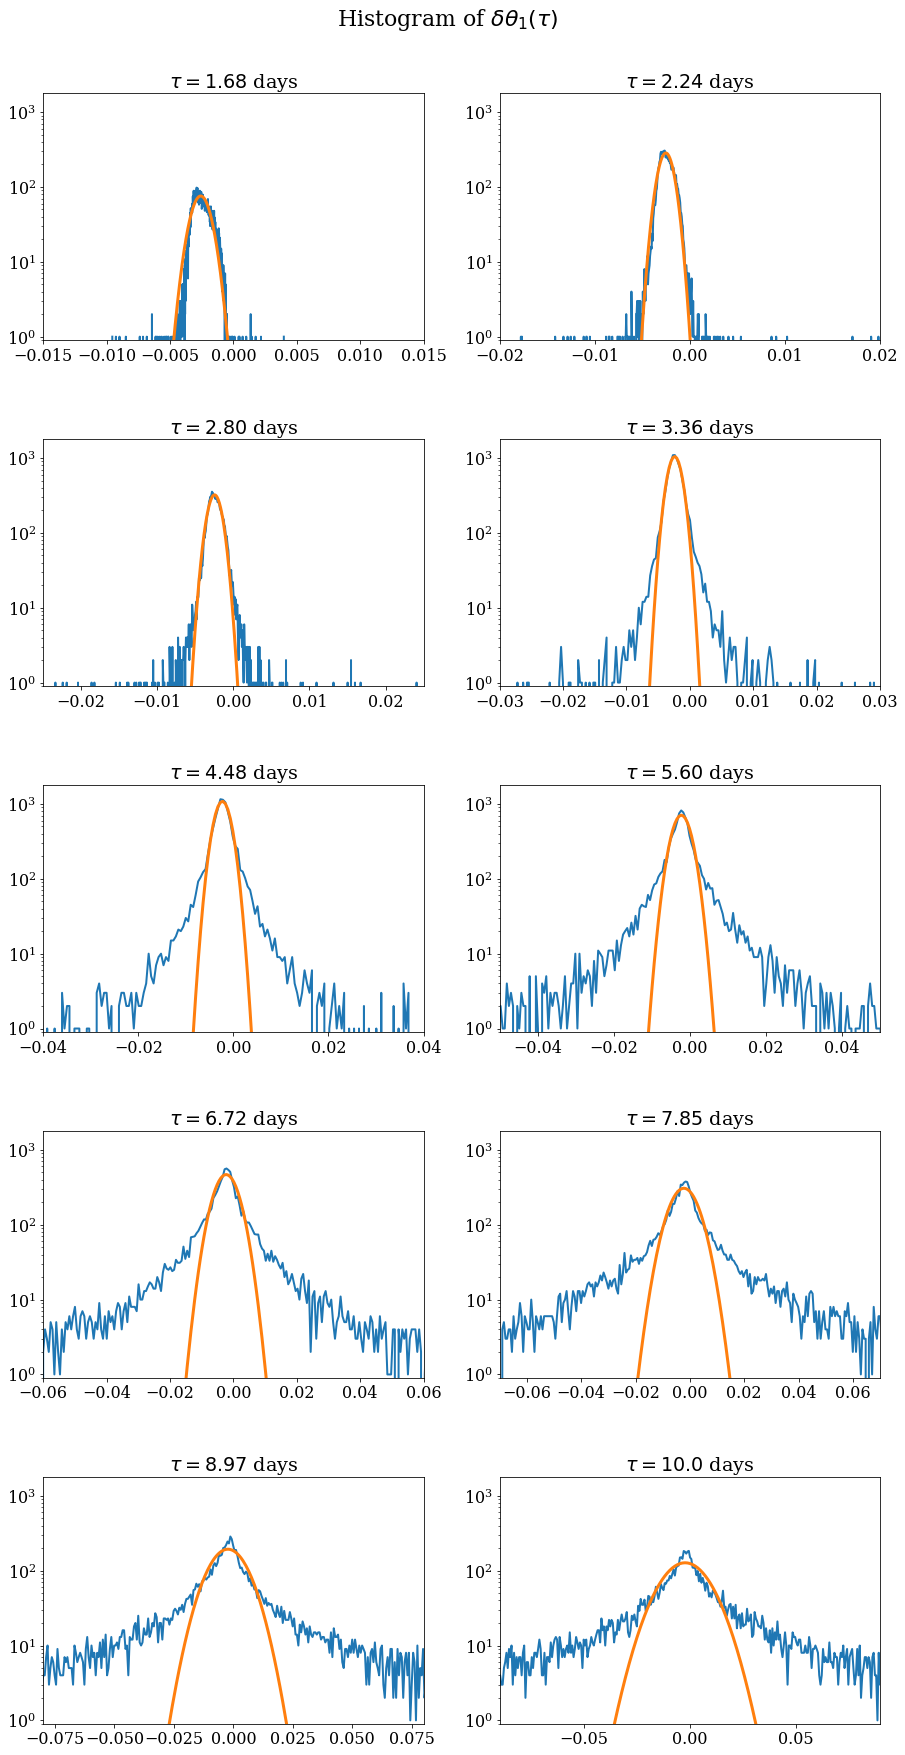

In [68]:
%%time

var = 10
til = [15]+list(range(20,91,10))
til.insert(2,25)
til = np.array(til)
nbins = [1000]*len(til)
filtl = [0.3]*len(til)
xlim = til*[0.001]

gaussian_parameters = list()

fig, axs = plt.subplots(ncols=2, nrows=int(len(til)/2), figsize=(15,3*len(til)))
plt.subplots_adjust(hspace=0.4)
axsl = axs.flatten()

for i in range(len(til)):
    
    filt = filtl[i]
    ti = til[i]
    fdelta = deltay[abs(deltay[:,var,ti]) < filt, var, ti]
    #hist, bins, patchs = axsl[i].hist(fdelta, bins=nbins[i])
    hist, bins = np.histogram(fdelta, bins=nbins[i])
    bin_centres = bins[1:] - np.diff(bins)/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [number_of_perturbed_trajectories/nbins[i], -0.001, 0.001]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    gaussian_parameters.append(coeff)
    print(coeff[1],np.mean(fdelta))
    
    axsl[i].semilogy(bin_centres, hist, linewidth=2.)
    axsl[i].semilogy(bin_centres, gauss(bin_centres, *coeff), linewidth=3.)
    axsl[i].set_xlim(-xlim[i],xlim[i])
    axsl[i].set_ylim(0.9,1800.)
    axsl[i].set_title(r'$\tau='+str(ct*time[ti])[:4]+r'$ days')

    
gaussian_parameters = np.array(gaussian_parameters)
fig.suptitle(r'Histogram of $\delta '+vs[var]+r' (\tau)$', x=0.5, y=0.92, fontsize=22)

fig.savefig('./fig07.pdf', dpi=300);

Computing the filtered mean and variance of the tangent trajectories to obtain the response on the average

In [69]:
%%time

var = 10
nbins = 1000
filt = 3.01

dyfiltm = list([np.zeros(ndim)])
dyfiltvar = list([np.zeros(ndim)])
dyfiltm2 = list([np.zeros(ndim)])


for ti in range(1,deltay.shape[2]):
    fdelta = np.ma.masked_where(abs(deltay[:,:,ti]) > filt, deltay[:,:,ti])
    fdelta2 = np.ma.masked_where(abs(deltay2[:,:,ti]) > filt/2, deltay2[:,:,ti])
    dyfiltm.append(np.mean(fdelta, axis=0).data)
    dyfiltvar.append(np.var(fdelta, axis=0).data)
    dyfiltm2.append(np.mean(fdelta2, axis=0).data)

dyfiltm = np.array(dyfiltm)
dyfiltvar = np.array(dyfiltvar)
dyfiltm2 = np.array(dyfiltm2)

dyfiltm = dyfiltm.T
dyfiltm2 = dyfiltm2.T
dyfiltvar = dyfiltvar.T


CPU times: user 3.64 s, sys: 435 ms, total: 4.07 s
Wall time: 4.08 s


Computing the response theory mean and variance at time $\tau$

In [70]:
mean_traj_model_rt = mean_traj_model0 + dyfiltm

var_traj_model_rt = (var_traj_model0 + mean_traj_model0**2) + dyfiltm2 - mean_traj_model_rt**2


Plotting the response theory results (figure 6 of the manuscript)

In [71]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,4))

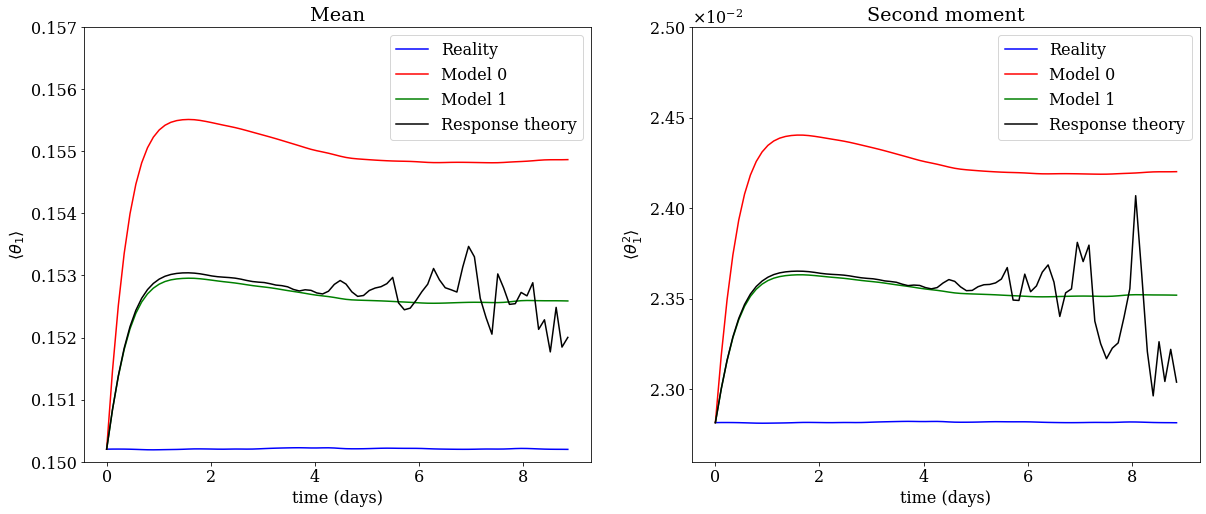

In [72]:
var = 10
mt=80

fig = plt.figure(figsize=(20,8))
axi = fig.add_subplot(121)

#Reality
plt.plot(ct*time[:mt], mean_traj_reality[var,:mt], color="b", label=r'Reality')

#Model
plt.plot(ct*time[:mt], mean_traj_model0[var,:mt], color="r", label=r'Model 0')
plt.plot(ct*time[:mt], mean_traj_model[var,:mt], color="g", label=r'Model 1')
plt.plot(ct*time[:mt], mean_traj_model_rt[var,:mt], color="k", label=r'Response theory', ls='-')

plt.legend()
plt.xlabel(r"time (days)")
plt.ylabel('$\langle '+vs[var]+r' \rangle $')
plt.ylim(0.15,0.157)
plt.title('Mean');

axi = fig.add_subplot(122)

#Reality
plt.plot(ct*time[:mt], var_traj_reality[var,:mt]+mean_traj_reality[var,:mt]**2, color="b", label=r'Reality')

#Model
plt.plot(ct*time[:mt], var_traj_model0[var,:mt]+mean_traj_model0[var,:mt]**2, color="r", label=r'Model 0')
plt.plot(ct*time[:mt], var_traj_model[var,:mt]+mean_traj_model[var,:mt]**2, color="g", label=r'Model 1');
plt.plot(ct*time[:mt], var_traj_model0[var,:mt]+mean_traj_model0[var,:mt]**2+dyfiltm2[var,:mt], color="k", label=r'Response theory', ls='-')

axi.yaxis.set_major_formatter(formatter)

plt.legend()
plt.xlabel(r"time (days)")
plt.ylabel(r'$ \langle'+vs[var]+r'^2 \rangle$');
plt.ylim(2.26e-2,2.5e-2)

plt.title('Second moment');

fig.savefig('./fig06.pdf', dpi=300);

Computing the postprocessing coefficients corrected by response theory

In [73]:
beta_rt =  np.nan_to_num(np.sqrt(var_traj_reality) / np.sqrt(var_traj_model_rt))
alpha_rt = mean_traj_reality - beta_rt * mean_traj_model_rt

Plotting the corrected coefficients (figure 7 of the manuscript)

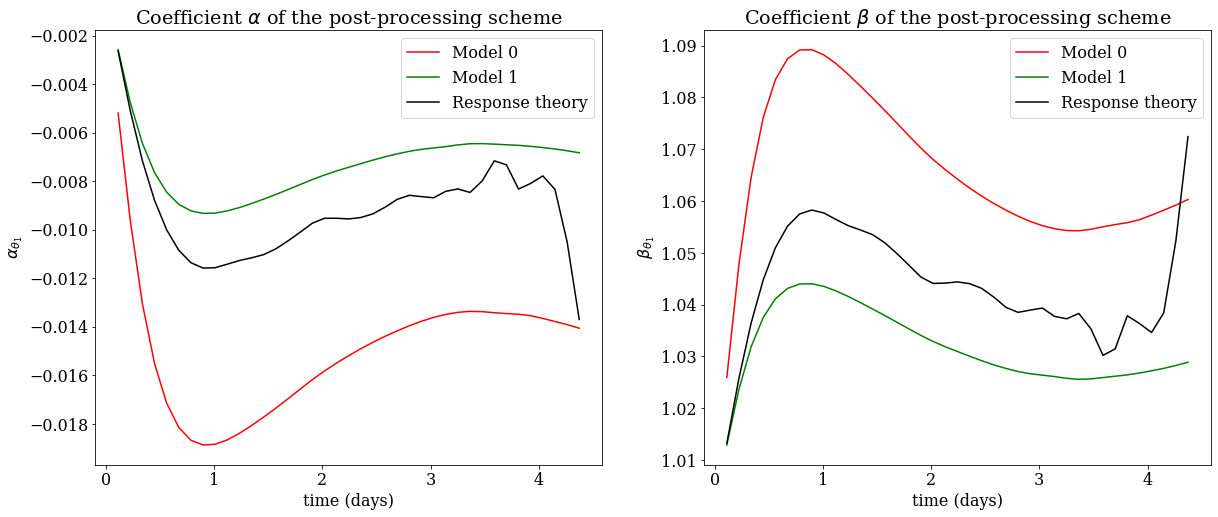

In [74]:
var = 10
mt=40

fig = plt.figure(figsize=(20,8))
axi = fig.add_subplot(121)

plt.plot(ct*time0[1:mt], alpha0[var, 1:mt], label=r'Model 0', color='r')
plt.plot(ct*time0[1:mt], alpha[var, 1:mt], label=r'Model 1', color='g')

plt.plot(ct*time0[1:mt], alpha_rt[var, 1:mt], label=r'Response theory', color='k')

plt.ylabel(r'$\alpha_{'+vs[var]+'}$')


plt.legend()
plt.xlabel(r"time (days)")
plt.title(r'Coefficient $\alpha$ of the post-processing scheme')
axi = fig.add_subplot(122)

plt.plot(ct*time0[1:mt], beta0[var, 1:mt], label=r'Model 0', color='r')
plt.plot(ct*time0[1:mt], beta[var, 1:mt], label=r'Model 1', color='g')

plt.plot(ct*time0[1:mt], beta_rt[var, 1:mt], label=r'Response theory', color='k')
plt.ylabel(r'$\beta_{'+vs[var]+'}$')

plt.legend()
plt.xlabel(r"time (days)")
plt.title(r'Coefficient $\beta$ of the post-processing scheme');

fig.savefig('./fig08.pdf', dpi=300);

Releasing the tangent integrator memory

In [75]:
tgls_integrator.terminate()

Loading the previously saved trajectories

In [76]:
traj_model0 = np.load('model0_trajectories.npz')['arr_0']
traj_model1 = np.load('model1_trajectories.npz')['arr_0']
traj_reality = np.load('reality_trajectories.npz')['arr_0']


Plotting the extremes of the distribution in the phase space

CPU times: user 195 ms, sys: 66.6 ms, total: 261 ms
Wall time: 260 ms


Text(0, 0.5, '$\\psi_{3}$')

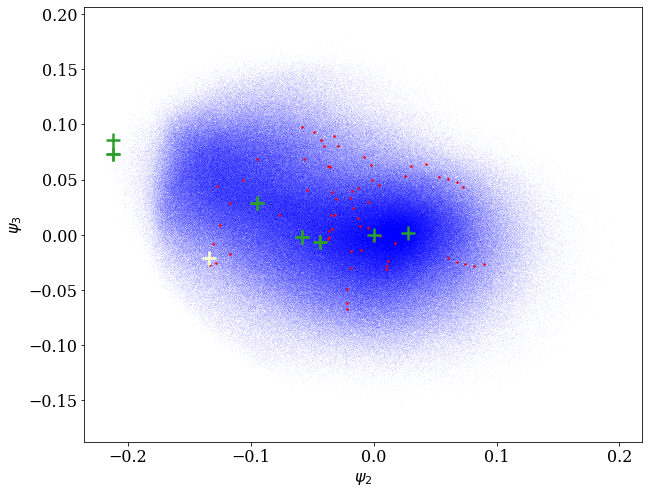

In [77]:
%%time

outval_i = abs(deltay[:,var])  > 10000000*abs(gaussian_parameters[-1,-1])
im = np.argmax(abs(deltay[:,var]))
im = np.unravel_index(im, deltay[:,var].shape)

varx = 1
vary = 2
plt.figure(figsize=(10, 8))

vara = traj_model0[:number_of_perturbed_trajectories,varx]
varb = traj_model0[:number_of_perturbed_trajectories,vary]
plt.plot(vara[outval_i], varb[outval_i], marker='o', ms=1.5, ls='', zorder=100., color='r')
plt.plot(vara, varb, marker='o', ms=0.01, ls='', color='b')
plt.plot(model0_fixed_point[:,varx], model0_fixed_point[:,vary], marker='+', ms=14., markeredgewidth=2.5, color='tab:green', ls='', zorder=200.)
plt.plot(vara[im[0],im[1]], varb[im[0],im[1]], marker='+', ms=14., markeredgewidth=2.5, color='xkcd:ivory', ls='', zorder=200.)


del vara, varb
plt.xlabel(r'$'+vs[varx]+r'$')
plt.ylabel(r'$'+vs[vary]+r'$');


## Evaluation of the correction obtained with the various coefficients

Computing the scores

In [78]:
model0_rms = np.mean((traj_reality - traj_model0)**2, axis=0)
model1_rms = np.mean((traj_reality - traj_model1)**2, axis=0)


In [79]:
model0corr_rms = np.mean((traj_reality - (alpha0 + beta0 * traj_model0))**2, axis=0)
model1corr_rms = np.mean((traj_reality - (alpha + beta * traj_model1))**2, axis=0)
model1corr0_rms = np.mean((traj_reality - (alpha0 + beta0 * traj_model1))**2, axis=0)
model1corr_rt_rms = np.mean((traj_reality - (alpha_rt + beta_rt * traj_model1))**2, axis=0)

In [80]:
model0corr_var = np.var(alpha0 + beta0 * traj_model0, axis=0)
model1corr_var = np.var(alpha + beta * traj_model1, axis=0)
model1corr0_var = np.var(alpha0 + beta0 * traj_model1, axis=0)
model1corr_rt_var = np.var(alpha_rt + beta_rt * traj_model1, axis=0)

In [81]:
model0corr_mean = np.mean(alpha0 + beta0 * traj_model0, axis=0)
model1corr_mean = np.mean(alpha + beta * traj_model1, axis=0)
model1corr0_mean = np.mean(alpha0 + beta0 * traj_model1, axis=0)
model1corr_rt_mean = np.mean(alpha_rt + beta_rt * traj_model1, axis=0)

Plotting the results (figure 10 of the manuscript)

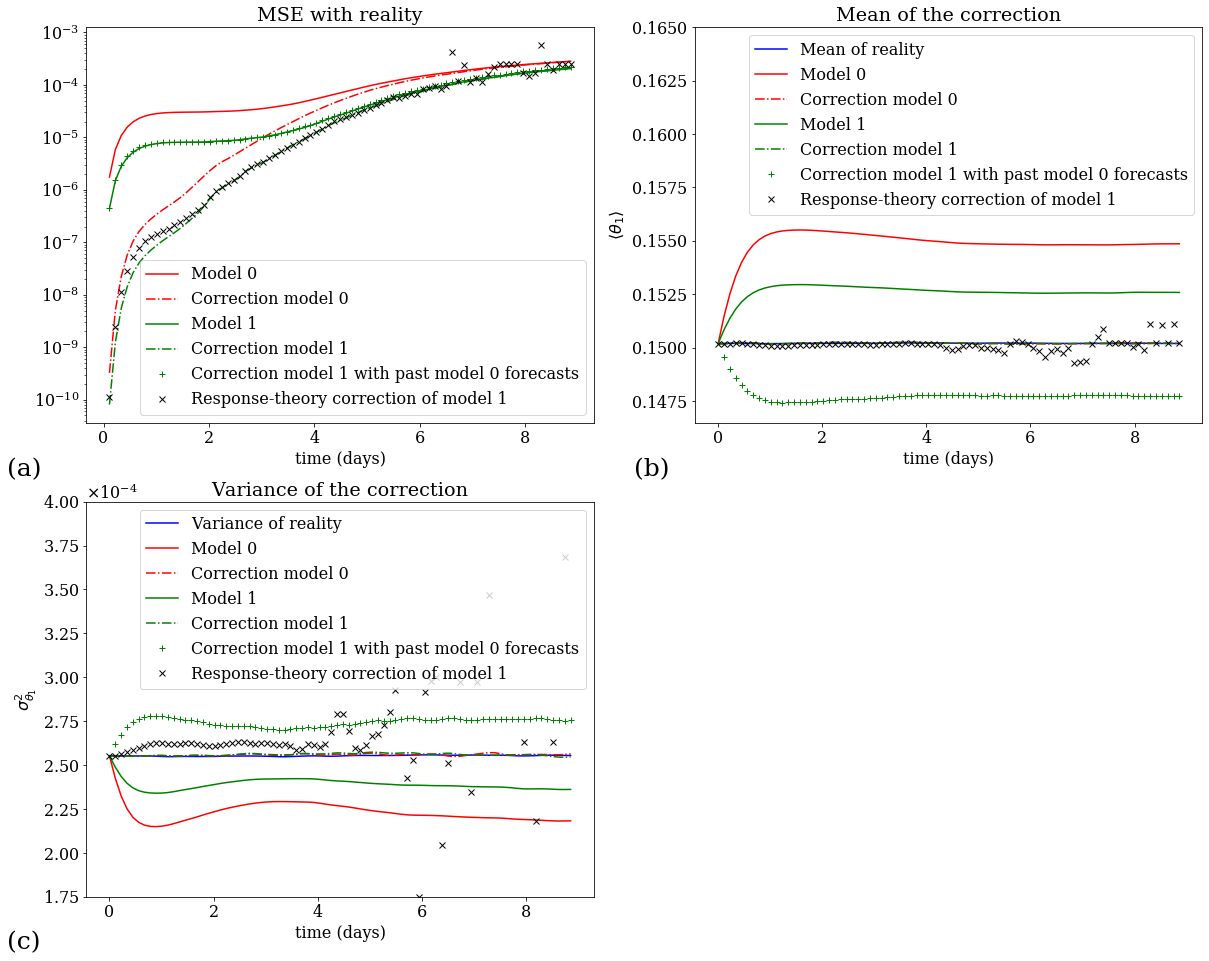

In [82]:
var = 10
mt=80

fig = plt.figure(figsize=(20,16))
axi = fig.add_subplot(221)

plt.semilogy(ct*time[1:mt], model0_rms[var, 1:mt], color='r', label='Model 0')
plt.semilogy(ct*time[1:mt], model0corr_rms[var, 1:mt], color='r', ls='-.', label='Correction model 0')
#plt.semilogy(time, model0_rms[var]-model0corr_rms[var])

plt.semilogy(ct*time[1:mt], model1_rms[var, 1:mt], color='g', label='Model 1')
plt.semilogy(ct*time[1:mt], model1corr_rms[var, 1:mt], color='g', ls='-.', label='Correction model 1')#""##
plt.semilogy(ct*time[1:mt], model1corr0_rms[var, 1:mt], color='g', ls='', marker='+', label='Correction model 1 with past model 0 forecasts')
plt.semilogy(ct*time[1:mt], model1corr_rt_rms[var, 1:mt], color='k', ls=' ', marker='x', label='Response-theory correction of model 1')

plt.xlabel('time (days)')
plt.title('MSE with reality')
plt.legend()

axi = fig.add_subplot(222)

plt.plot(ct*time[0:mt], mean_traj_reality[var, 0:mt], color='b', label='Mean of reality')
plt.plot(ct*time[0:mt], mean_traj_model0[var, 0:mt], color='r', label='Model 0')
plt.plot(ct*time[0:mt], model0corr_mean[var, 0:mt], color='r', ls='-.', label='Correction model 0')

plt.plot(ct*time[0:mt], mean_traj_model[var, 0:mt], color='g', label='Model 1')
plt.plot(ct*time[0:mt], model1corr_mean[var, 0:mt], color='g', ls='-.', label='Correction model 1')
plt.plot(ct*time[1:mt], model1corr0_mean[var, 1:mt], color='g', ls='', marker='+', label='Correction model 1 with past model 0 forecasts')
plt.plot(ct*time[0:mt], model1corr_rt_mean[var, 0:mt], color='k', ls=' ', marker='x', label='Response-theory correction of model 1')

plt.xlabel('time (days)')
plt.ylabel(r'$\langle '+vs[var]+r'\rangle$')
axi.yaxis.set_major_formatter(formatter)

plt.ylim(0.1465,0.165)
plt.title('Mean of the correction')
plt.legend()

axi = fig.add_subplot(223)

plt.plot(ct*time[0:mt], var_traj_reality[var, 0:mt], color='b', label='Variance of reality')
plt.plot(ct*time[0:mt], var_traj_model0[var, 0:mt], color='r', label='Model 0')
plt.plot(ct*time[0:mt], model0corr_var[var, 0:mt], color='r', ls='-.', label='Correction model 0')

plt.plot(ct*time[0:mt], var_traj_model[var, 0:mt], color='g', label='Model 1')
plt.plot(ct*time[0:mt], model1corr_var[var, 0:mt], color='g', ls='-.', label='Correction model 1')
plt.plot(ct*time[1:mt], model1corr0_var[var, 1:mt], color='g', ls='', marker='+', label='Correction model 1 with past model 0 forecasts')
plt.plot(ct*time[0:mt], model1corr_rt_var[var, 0:mt], color='k', ls=' ', marker='x', label='Response-theory correction of model 1')

plt.xlabel('time (days)')
plt.ylabel(r'$\sigma^2_{'+vs[var]+'}$')
axi.yaxis.set_major_formatter(formatter)

plt.title('Variance of the correction')
plt.ylim(0.000175,0.00040)
plt.legend(loc=1)

fig.text(0.07,0.08,'(c)', fontsize=25)
#fig.text(0.505,0.08,'(d)', fontsize=25)

fig.text(0.07,0.49,'(a)', fontsize=25)
fig.text(0.505,0.49,'(b)', fontsize=25)


fig.savefig('./fig10.pdf', dpi=300);

Evaluation of the impact of the statistics size

In [83]:
%%time

var = 10
filt = 3.01
esize = [number_of_perturbed_trajectories,1000,500,100,20]

dyl = list([dyfiltm])
dy2l = list([dyfiltm2])

for s in esize[1:]:

    dy1 = list([np.zeros(ndim)])
    dy2 = list([np.zeros(ndim)])


    for ti in range(1,deltay.shape[2]):
        fdelta = np.ma.masked_where(abs(deltay[:s,:,ti]) > filt, deltay[:s,:,ti])
        fdelta2 = np.ma.masked_where(abs(deltay2[:s,:,ti]) > filt/2, deltay2[:s,:,ti])
    
        dy1.append(np.mean(fdelta, axis=0).data)
        dy2.append(np.mean(fdelta2, axis=0).data)
    
    dy1 = np.array(dy1)
    dy2 = np.array(dy2)

    dy1 = dy1.T
    dy2 = dy2.T
    
    dyl.append(dy1)
    dy2l.append(dy2)

CPU times: user 482 ms, sys: 10.7 ms, total: 492 ms
Wall time: 490 ms


In [84]:
mean_traj_model_rtl = list()
var_traj_model_rtl = list()

for i in range(len(esize)):

    mean_traj_model_rtl.append(mean_traj_model0 + dyl[i])

    var_traj_model_rtl.append(var_traj_model0 + mean_traj_model0**2 + dy2l[i] - mean_traj_model_rtl[-1]**2)


In [85]:
alpha_rtl = list()
beta_rtl = list()

for i in range(len(esize)):

    beta_rtl.append(np.nan_to_num(np.sqrt(var_traj_reality) / np.sqrt(var_traj_model_rtl[i])))
    alpha_rtl.append(mean_traj_reality - beta_rtl[-1] * mean_traj_model_rtl[i])

In [86]:
model1corr_rtl_rms = list()

for i in range(len(esize)):

    model1corr_rtl_rms.append(np.mean((traj_reality - (alpha_rtl[i] + beta_rtl[i] * traj_model1))**2, axis=0))

Plotting the result

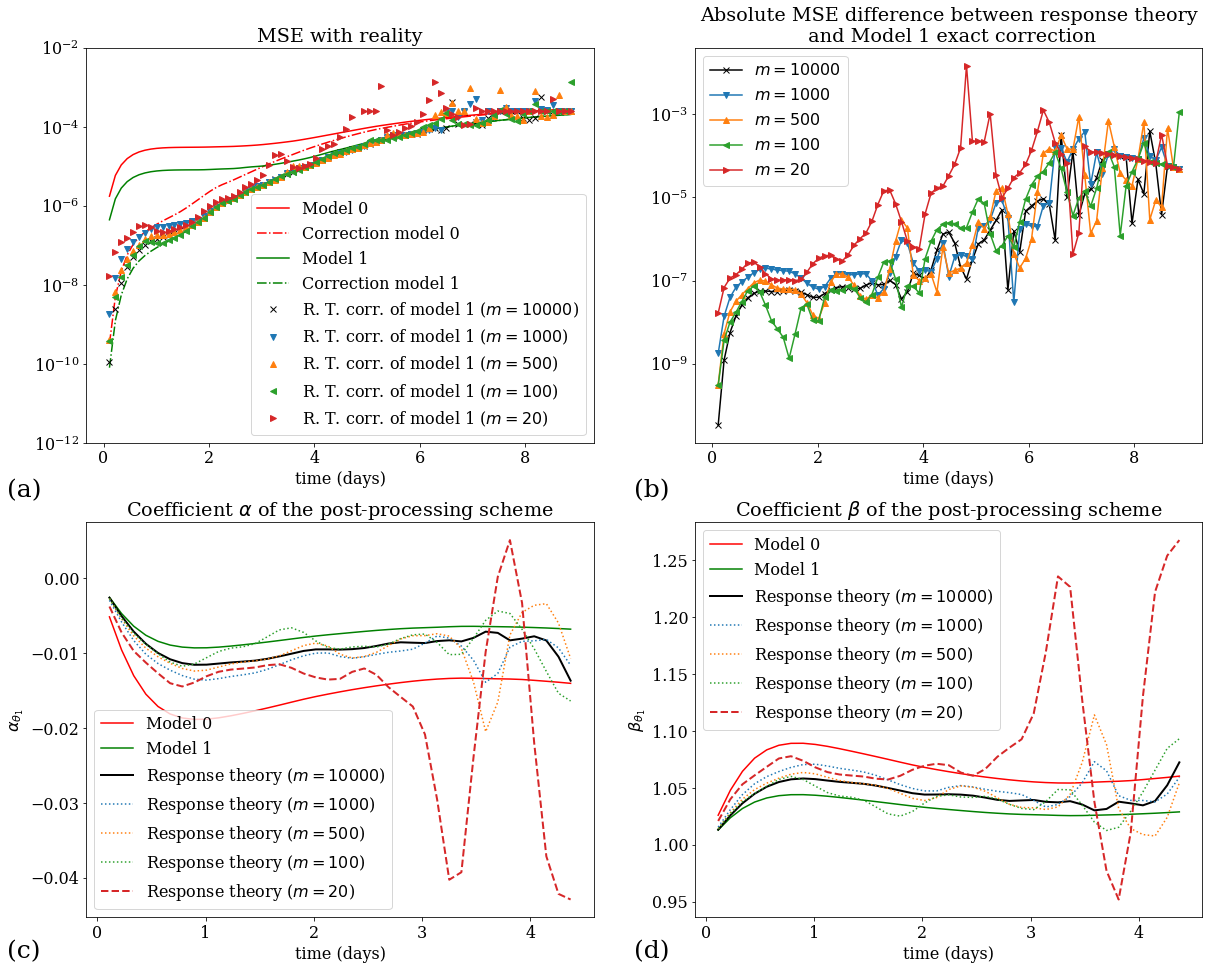

In [87]:
var = 10
mt=80

from matplotlib.markers import MarkerStyle
ml = list(MarkerStyle.markers.keys())

fig = plt.figure(figsize=(20,16))
axi = fig.add_subplot(221)

plt.semilogy(ct*time[1:mt], model0_rms[var, 1:mt], color='r', label='Model 0')
plt.semilogy(ct*time[1:mt], model0corr_rms[var, 1:mt], color='r', ls='-.', label='Correction model 0')

plt.semilogy(ct*time[1:mt], model1_rms[var, 1:mt], color='g', label='Model 1')
plt.semilogy(ct*time[1:mt], model1corr_rms[var, 1:mt], color='g', ls='-.', label='Correction model 1')#""##
plt.semilogy(ct*time[1:mt], model1corr_rtl_rms[0][var, 1:mt], ls=' ', color='k', marker='x', label='R. T. corr. of model 1 ($m='+str(esize[0])+'$)')

for i in range(1,len(esize)):
    plt.semilogy(ct*time[1:mt], model1corr_rtl_rms[i][var, 1:mt], ls=' ', marker=ml[i+2], label='R. T. corr. of model 1 ($m='+str(esize[i])+'$)')

    
plt.ylim(1e-12,0.01)
plt.xlabel('time (days)')
plt.title('MSE with reality')
plt.legend()

axi = fig.add_subplot(222)

plt.semilogy(ct*time[1:mt], np.abs(model1corr_rtl_rms[0][var, 1:mt] - model1corr_rms[var, 1:mt]), ls='-', marker='x', color='k', label='$m='+str(esize[0])+'$')

for i in range(1,len(esize)):
    plt.semilogy(ct*time[1:mt], np.abs(model1corr_rtl_rms[i][var, 1:mt] - model1corr_rms[var, 1:mt]), ls='-', marker=ml[i+2], label='$m='+str(esize[i])+'$')

plt.xlabel('time (days)')
plt.title('Absolute MSE difference between response theory\n and Model 1 exact correction')
plt.legend()

axi = fig.add_subplot(223)
mt=40

plt.plot(ct*time0[1:mt], alpha0[var, 1:mt], label=r'Model 0', color='r')
plt.plot(ct*time0[1:mt], alpha[var, 1:mt], label=r'Model 1', color='g')
plt.plot(ct*time[1:mt], alpha_rtl[0][var, 1:mt], ls='-', lw=2., color='k', label='Response theory ($m='+str(esize[0])+'$)')

for i in range(1,len(esize)-1):
    plt.plot(ct*time[1:mt], alpha_rtl[i][var, 1:mt], ls=':', label='Response theory ($m='+str(esize[i])+'$)')

plt.plot(ct*time[1:mt], alpha_rtl[-1][var, 1:mt], ls='--', lw=2., label='Response theory ($m='+str(esize[-1])+'$)')


plt.ylabel(r'$\alpha_{'+vs[var]+'}$')
plt.xlabel(r'time (days)')
plt.title(r'Coefficient $\alpha$ of the post-processing scheme')
plt.legend();

axi = fig.add_subplot(224)

plt.plot(ct*time0[1:mt], beta0[var, 1:mt], label=r'Model 0', color='r')
plt.plot(ct*time0[1:mt], beta[var, 1:mt], label=r'Model 1', color='g')
plt.plot(ct*time[1:mt], beta_rtl[0][var, 1:mt], ls='-', lw=2., color='k', label='Response theory ($m='+str(esize[0])+'$)')

for i in range(1,len(esize)-1):
    plt.plot(ct*time[1:mt], beta_rtl[i][var, 1:mt], ls=':', label='Response theory ($m='+str(esize[i])+'$)')

plt.plot(ct*time[1:mt], beta_rtl[-1][var, 1:mt], ls='--', lw=2., label='Response theory ($m='+str(esize[-1])+'$)')

plt.ylabel(r'$\beta_{'+vs[var]+'}$')
plt.xlabel(r'time (days)')
plt.title(r'Coefficient $\beta$ of the post-processing scheme')
plt.legend();

fig.text(0.07,0.09,'(c)', fontsize=25)
fig.text(0.505,0.09,'(d)', fontsize=25)

fig.text(0.07,0.49,'(a)', fontsize=25)
fig.text(0.505,0.49,'(b)', fontsize=25);

# fig.savefig('./fig11.pdf', dpi=300);